## Методы обработки естественных языков

### Практическая работа 2

Зависимости необходимые для запуска:
- [spacy](https://spacy.io)
- [nltk](https://www.nltk.org)
- [matplotlib](https://matplotlib.org)
- [seaborn](https://seaborn.pydata.org)
- [scikit-learn](https://scikit-learn.org/stable/)

In [1]:
import re
import spacy
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
!spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.9 MB/s  0:00:03 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
CHAPTERS_NUM = 16  # количество глав, которые будут использоваться в анализе

In [4]:
def extract_book_from_gutenberg_ebook(text):
    m = re.search(
        r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*(.*?)\*\*\* END OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*",
        text,
        flags=re.DOTALL | re.IGNORECASE
    )
    if m:
        return m.group(1).strip()
    return ""

In [5]:
book_text = ""
with open("data/book.txt", "r") as f:
    book_text = f.read()

extracted_book = extract_book_from_gutenberg_ebook(book_text)
if extracted_book != "":
    book_text = extracted_book

In [6]:
book_text[:100]

'THE MAN WHO LAUGHS\n\nA Romance of English History\n\nBy\n\nVICTOR HUGO\n\n\n\n\nCONTENTS\n\n\n\n\nPreliminary Chapt'

In [7]:
def split_chapters_content(book_text):
    pattern = re.compile(
        r"(?m)^CHAPTER\s+[IVXLCDM]+\.\s*\n"
        r".*?\n"
        r"(.*?)(?=^CHAPTER\s+[IVXLCDM]+\.|\Z)",
        re.DOTALL
    )
    chapters = [match.group(1).strip() for match in pattern.finditer(book_text)]
    return chapters

In [8]:
chapters = split_chapters_content(book_text)
for i in range(CHAPTERS_NUM):
    print(f"Глава {i+1}: {chapters[i][:20]}...")

Глава 1: An obstinate north w...
Глава 2: This is what an obse...
Глава 3: The child remained m...
Глава 4: What kind of band wa...
Глава 5: It might be about se...
Глава 6: The child was before...
Глава 7: He ran until he was ...
Глава 8: The snowstorm is one...
Глава 9: While the hooker was...
Глава 10: Two men on board the...
Глава 11: The old man whom the...
Глава 12: The mist was deforme...
Глава 13: Through his growing ...
Глава 14: On their part it was...
Глава 15: The characteristic o...
Глава 16: The skipper, at the ...


### Нормализация

In [9]:
nlp = spacy.load("en_core_web_sm")

def normalize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(lemmas)

In [10]:
normalized_chapters = []
for i in range(CHAPTERS_NUM):
    normalized_chapters.append(normalize_text(chapters[i]))

In [11]:
print("Главы книги после нормализации")
for i in range(CHAPTERS_NUM):
    print(f"    Глава {i+1}: {normalized_chapters[i][:20]}...")

Главы книги после нормализации
    Глава 1: obstinate north wind...
    Глава 2: observer close hand ...
    Глава 3: child remain motionl...
    Глава 4: kind band leave chil...
    Глава 5: seven evening wind d...
    Глава 6: child thing dumb won...
    Глава 7: run breathless rando...
    Глава 8: snowstorm mystery oc...
    Глава 9: hooker gulf portland...
    Глава 10: man board craft abso...
    Глава 11: old man chief band n...
    Глава 12: mist deform sort ine...
    Глава 13: grow preoccupation d...
    Глава 14: wild jubilee delight...
    Глава 15: characteristic snows...
    Глава 16: skipper helm burst b...


### Анализатор тональности

In [12]:
nltk.download("vader_lexicon", quiet=True)

def get_text_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return max(scores, key=scores.get)

In [13]:
labels_dict = {
    "neu": "нейтральную",
    "pos": "положительную",
    "neg": "отрицательную",
    "compound": "сложную",
}

for i in range(CHAPTERS_NUM):
    print(f"Глава {i+1} имеет {labels_dict[get_text_sentiment(normalized_chapters[i])]} тональность")

Глава 1 имеет сложную тональность
Глава 2 имеет сложную тональность
Глава 3 имеет нейтральную тональность
Глава 4 имеет нейтральную тональность
Глава 5 имеет нейтральную тональность
Глава 6 имеет нейтральную тональность
Глава 7 имеет нейтральную тональность
Глава 8 имеет нейтральную тональность
Глава 9 имеет нейтральную тональность
Глава 10 имеет нейтральную тональность
Глава 11 имеет сложную тональность
Глава 12 имеет нейтральную тональность
Глава 13 имеет нейтральную тональность
Глава 14 имеет нейтральную тональность
Глава 15 имеет нейтральную тональность
Глава 16 имеет нейтральную тональность


### Векторизация

In [14]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2)
tfidf_model = vectorizer.fit_transform(normalized_chapters)

In [15]:
feature_names = vectorizer.get_feature_names_out()

print(f"10 признаков из матрицы TF-IDF: {', '.join(feature_names[:10])}")

10 признаков из матрицы TF-IDF: aback, abaft, abandon, abrupt, absolutely, absorb, abyss, accept, acceptance, accomplice


### LSA

In [16]:
TOPICS_NUM = 4  # количество тем

lsa = TruncatedSVD(n_components=TOPICS_NUM, random_state=0)
lsa_model = lsa.fit_transform(tfidf_model)

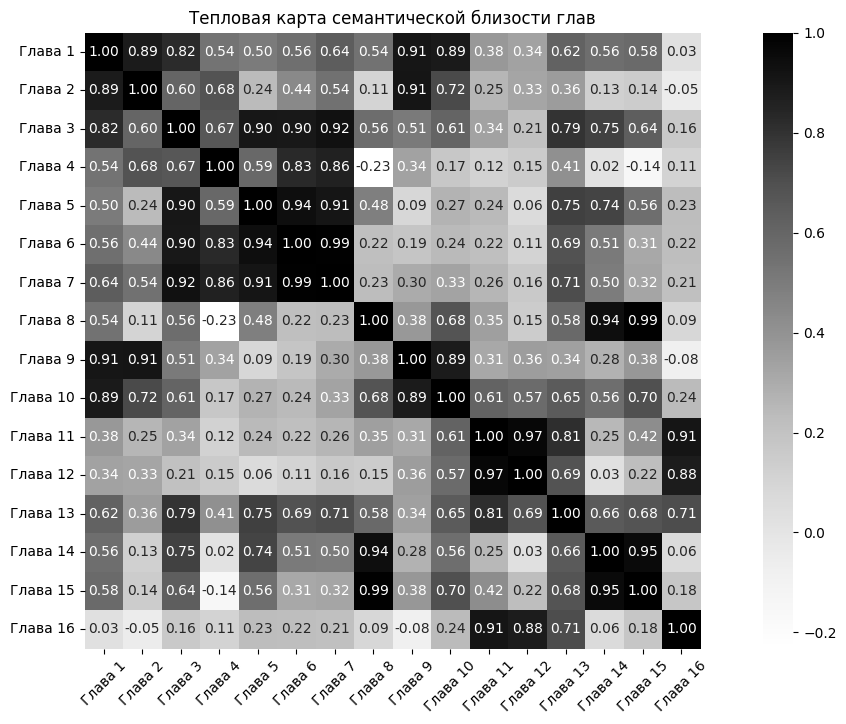

In [17]:
similarity_matrix = cosine_similarity(lsa_model)

labels = [f"Глава {i+1}" for i in range(CHAPTERS_NUM)]
plt.figure(figsize=(16, 8))
sns.heatmap(similarity_matrix,
            xticklabels=labels,
            yticklabels=labels,
            cmap="Greys",
            annot=True,
            fmt=".2f",
            square=True)
plt.title("Тепловая карта семантической близости глав")
plt.xticks(rotation=45)
plt.show()

Можно заметить, что первые 7 глав имеют высокую семантическую близость друг с другом.\
Также глава под номером 13 является наиболее схожей с остальными главами, чем другие.

In [18]:
n_words = 5
print(f"Список из {n_words} самых значимых слов в теме")
for i, topic in enumerate(lsa.components_):
    idxs = topic.argsort()[-n_words:][::-1]
    print(f"    Тема {i+1}: {', '.join([feature_names[idx] for idx in idxs])}")

Список из 5 самых значимых слов в теме
    Тема 1: child, hooker, wave, doctor, time
    Тема 2: doctor, skipper, bell, yes, pocket
    Тема 3: child, basque, doctor, skipper, group
    Тема 4: bell, doctor, child, skipper, chain
